# Applying Bi-LSTM Model to Political Speech - Predicting Sentiment Scores
### POLI 179 Project - Brenna Farris and Eden Stewart

Further examining this research: https://doi.org/10.1080/10584609.2021.1952497

Data accessed from: https://github.com/ccochrane/emotionTranscripts

GitHub Repo of Project: https://github.com/bafarris/speech-sentiment-bilstm

## Loading Libraries and Dataset

In [209]:
# import standard libraries
import numpy as np
import pandas as pd
import random
import requests
from io import BytesIO
from zipfile import ZipFile
from google.colab import files

# import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# import natural language processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

# download nltk datasets
nltk.download('stopwords')
nltk.download('punkt')

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# import deep learning libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [210]:
# set random seeds
np.random.seed(88)
random.seed(88)
tf.random.set_seed(88)

In [211]:
# load dataset (contains human coder sentiment scores and segments of corpus)
full_df = pd.read_csv(
    'https://raw.githubusercontent.com/bafarris/speech-sentiment-bilstm/main/data/w2vScores.csv',
    sep=','
)

# examine dataset
print(full_df.head())
rows = full_df.shape[0]
print(f"Number of rows: {rows}")
columns = full_df.shape[1]
print(f"Number of columns: {columns}")

   Unnamed: 0        IDMain  countedWords        date  \
0           0  2017 12 13 0            13  2017-12-13   
1           1  2017 12 13 1             8  2017-12-13   
2           2  2017 12 13 2            16  2017-12-13   
3           3  2017 12 13 3            30  2017-12-13   
4           4  2017 12 13 4             7  2017-12-13   

                                             english  \
0  I thought we usually hired an investigator to ...   
1  I hope they will be getting better than that i...   
2  We told Canadians that we would run deficits, ...   
3  The problem was that they fired 700 people in ...   
4  We did not create the Phoenix problem, but we ...   

                                               floor  french  label party  \
0  Moi, je pensais qu'on embauchait d'habitude un...       1      1   NDP   
1  I hope they will be getting better than that i...       0      2   LIB   
2  We told Canadians that we would run deficits, ...       0      3   LIB   
3  The probl

In [212]:
# find minimum and maximum number in 'sentiment' column
min_sentiment = full_df['sentiment'].min()
max_sentiment = full_df['sentiment'].max()

# find range
range_sentiment = max_sentiment - min_sentiment

# examine results
print(f"Minimum sentiment score: {min_sentiment}")
print(f"Maximum sentiment score: {max_sentiment}")
print(f"Range of sentiment scores: {range_sentiment}")

Minimum sentiment score: -1.240414334860232
Maximum sentiment score: 2.362722101791796
Range of sentiment scores: 3.603136436652028


## Pre-Processing

In [213]:
# load stop words
stop_words = set(stopwords.words('english'))

# tokenize (lowercase, split text into words, remove stop words)
def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return words

# apply preprocessing to 'english' column (contains corpus segments)
full_df['tokens'] = full_df['english'].apply(preprocess_text)

# prepare sentences for word2vec
sentences = full_df['tokens'].tolist()

# train word2vec model
word2vec_model_sample = Word2Vec(sentences, vector_size=300, window=6, min_count=10, epochs=5)

# save model
word2vec_model_sample.save("word2vec_sample.model")

# print model vocabulary
print(word2vec_model_sample.wv.key_to_index)

{'minister': 0, 'speaker': 1, 'government': 2, 'canadians': 3, 'canada': 4, 'prime': 5, 'canadian': 6, 'work': 7, 'would': 8, 'liberals': 9, 'house': 10, 'people': 11, 'jobs': 12, 'new': 13, 'member': 14, 'us': 15, 'tax': 16, 'support': 17, 'members': 18, 'public': 19, 'plan': 20, 'going': 21, 'like': 22, 'get': 23, 'make': 24, 'know': 25, 'liberal': 26, 'one': 27, 'help': 28, 'working': 29, 'families': 30, 'said': 31, 'conservatives': 32, 'communities': 33, 'put': 34, 'national': 35, 'quebec': 36, 'also': 37, 'process': 38, 'country': 39, 'health': 40, 'years': 41, 'finance': 42, 'continue': 43, 'important': 44, 'year': 45, 'bill': 46, 'ensure': 47, 'take': 48, 'every': 49, 'commissioner': 50, 'need': 51, 'money': 52, 'across': 53, 'yesterday': 54, 'million': 55, 'system': 56, 'economy': 57, 'access': 58, 'ndp': 59, 'want': 60, 'last': 61, 'trade': 62, 'question': 63, 'conservative': 64, 'future': 65, 'many': 66, 'budget': 67, 'way': 68, 'women': 69, 'first': 70, 'indigenous': 71, 'ma

## Predict MSE (Target Variable [Sentiment Scores] Treated as Continuous Variables)



In [214]:
# define function to convert tokens to sequences of integers
def tokens_to_integers(tokens, word2vec_model):
    # filter out tokens that are not in word2vec vocabulary
    return [word2vec_model.wv.key_to_index[word] for word in tokens if word in word2vec_model.wv.key_to_index]

# apply function to 'tokens' column of 'full_df' + create column 'sequence'
full_df['sequence'] = full_df['tokens'].apply(lambda x: tokens_to_integers(x, word2vec_model_sample))

# pad sequences in 'sequence' column to maximum length of 100 + store as 'X'
X = pad_sequences(full_df['sequence'], maxlen=100)

# store 'sentiment' column as 'y'
y = full_df['sentiment']

# initalize minmaxscaler
scaler = MinMaxScaler(feature_range=(-1.24, 2.36))

# fit + transform 'y' values
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

# split 'X' + 'y_scaled' into training/test sets (20% of data reserved for test)
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=88)

# initialize sequential model
model = Sequential()

# add embedding layer with pre-trained word vectors
model.add(Embedding(input_dim=len(word2vec_model_sample.wv), output_dim=300, weights=[word2vec_model_sample.wv.vectors], input_length=100, trainable=False))

# add a bi-lstm layer (128 units)
model.add(Bidirectional(LSTM(128)))

# add dense layer with linear activation function
model.add(Dense(1, activation='linear'))

# compile model with adam optimizer + mean squared error
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# evaluate model on test set
mse = model.evaluate(X_test, y_test, verbose=0)[1]

# predict sentiment scores
y_pred_cont = model.predict(X_test)

# examine mse
print(f"Mean Squared Error on Test Set: {mse}")

7/7 [==============================] - 1s 95ms/step
Mean Squared Error on Test Set: 0.18704727292060852


## Predict F-1 and Accuracy Scores (Target Variable [Sentiment Scores] Treated as Binary Variables)

In [215]:
# initialize the model
model = Sequential()

# add embedding layer with pre-trained word vectors
model.add(Embedding(input_dim=len(word2vec_model_sample.wv), output_dim=300, weights=[word2vec_model_sample.wv.vectors], input_length=100, trainable=False))

# add a bi-lstm layer (128 units)
model.add(Bidirectional(LSTM(128)))

# add dense layer with sigmoid activation function (binary classification)
model.add(Dense(1, activation='sigmoid'))

# compile model with adam optimizer + binary cross entropy
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# evaluate model on test set
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]

# examine accuracy on test set
print(f"accuracy on test set: {accuracy}")

# generate predictions for the test set
y_pred = model.predict(X_test)

# convert y_test to numpy array
y_test_binary = np.array(y_test)

# binarize y_test_binary (values greater than 0 become 1, others remain 0)
y_test_binary = np.where(y_test_binary > 0, 1, 0)

# binarize predictions (round to the nearest integer)
y_pred_binary = [int(round(p[0])) for p in y_pred]

# calculate + examine accuracy
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"accuracy: {accuracy}")

# calculate + examine f-1 score
f1 = f1_score(y_test_binary, y_pred_binary)
print(f"f-1 score: {f1}")

accuracy on test set: 0.0
7/7 [==============================] - 2s 92ms/step
accuracy: 0.5196078431372549
f-1 score: 0.6838709677419356


## Visualize Results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

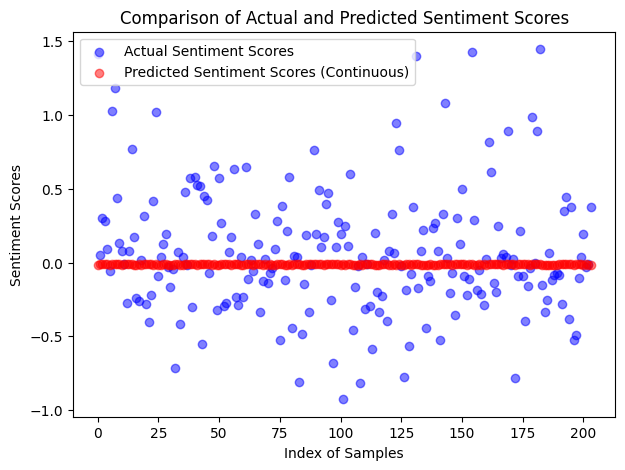

In [216]:
## continuous results

# create range of indices = length y_test
indices = range(len(y_test))

# create new figure
plt.figure(figsize=(7, 5))

# create scatter plot of actual sentiment scores (indices on x-axis + y_test on y-axis)
plt.scatter(indices, y_test, color='blue', alpha=0.5, label='Actual Sentiment Scores')

# create scatter plot of predicted sentiment scores (indices on x-axis + y_pred_cont on y-axis)
plt.scatter(indices, y_pred_cont, color='red', alpha=0.5, label='Predicted Sentiment Scores (Continuous)')

# title
plt.title('Comparison of Actual and Predicted Sentiment Scores')

# label x-axis
plt.xlabel('Index of Samples')

# label y-axis
plt.ylabel('Sentiment Scores')

# add legend
plt.legend()

# save plot to file
plt.savefig('sentiment_scores_cont.png')
files.download('sentiment_scores_cont.png')

# display plot
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

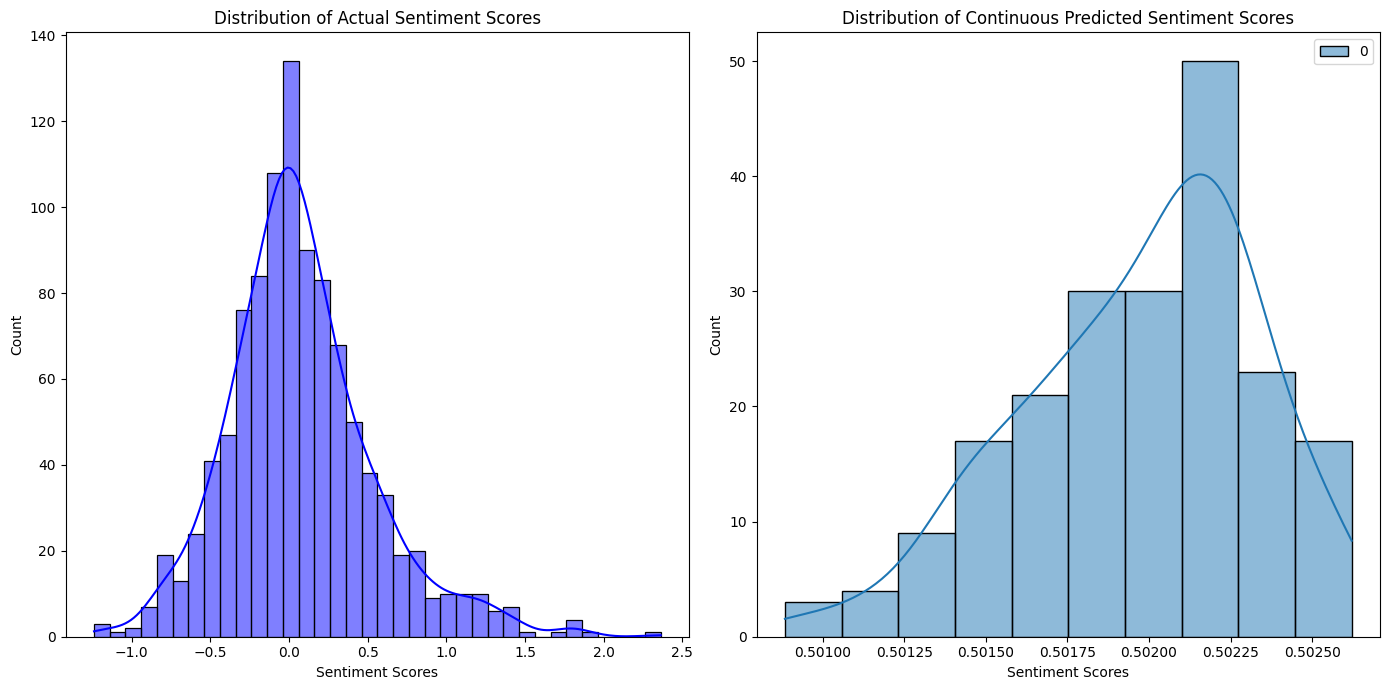

In [220]:
# create new figure
plt.figure(figsize=(14, 7))

# create a subplot
plt.subplot(1, 2, 1)

# create histogram (actual scores)
sns.histplot(y, color='blue', kde=True)

# title
plt.title('Distribution of Actual Sentiment Scores')

# label x-axis
plt.xlabel('Sentiment Scores')

# create another subplot
plt.subplot(1, 2, 2)

# create histogram (predicted scores))
sns.histplot(y_pred, color='red', kde=True)

# title
plt.title('Distribution of Continuous Predicted Sentiment Scores')

# label x-axis
plt.xlabel('Sentiment Scores')

# prevent overlapping
plt.tight_layout()

# save plots to file
plt.savefig('sentiment_scores_dist.png')
files.download('sentiment_scores_dist.png')

# display plots
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

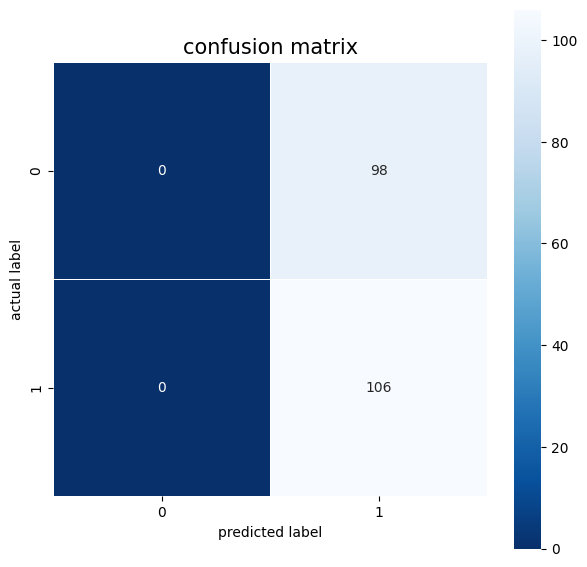

In [218]:
## binary results

# examine y_test_binary + y_pred_binary
confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# create new figure
plt.figure(figsize=(7,7))

# plot confusion matrix (heatmap)
sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r')

# y-axis label
plt.ylabel('actual label')

# x-axis label
plt.xlabel('predicted label')

# title
plt.title('confusion matrix', size = 15)

# save plot to file
plt.savefig('sentiment_scores_cm.png')
files.download('sentiment_scores_cm.png')

# display plot
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

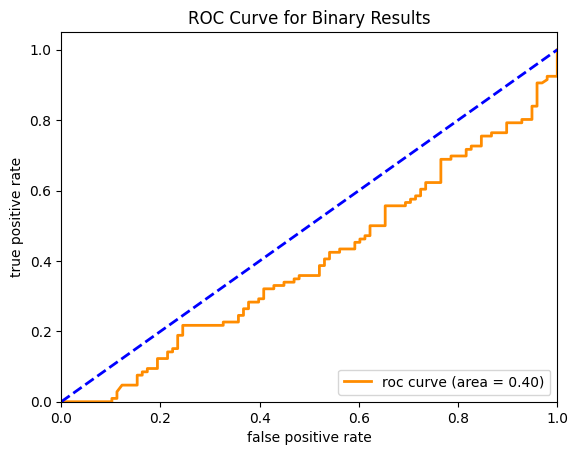

In [219]:
# calculate false positive rate + true positive rate
fpr, tpr, _ = roc_curve(y_test_binary, y_pred)

# calculate area under roc curve
roc_auc = auc(fpr, tpr)

# create new figure
plt.figure()

# set line width
lw = 2

# plot roc curve
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='roc curve (area = %0.2f)' % roc_auc)

# plot diagonal line
plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')

# set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# label x + y axis
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

# title
plt.title('ROC Curve for Binary Results')

# legend
plt.legend(loc="lower right")

# save plot to file
plt.savefig('sentiment_scores_roc.png')
files.download('sentiment_scores_roc.png')

# display plot
plt.show()
